# Creation of pretty figures for report

In [4]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.linear_model import LinearRegression
import tamar.tools.utilities as utils
import tamar.tools.plotting_funcs as plot
from tamar.tools.settings import CsvDir, ImgDir, PlotDir, Config
from scipy.signal import lombscargle
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.units as u

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames

from astropy.io import fits
import NEIDcode
import glob
from tqdm import tqdm


In [ ]:
plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

Read in velocities from csv.

In [6]:
# csv file with rv components
csv_file = os.path.join(CsvDir.NEID_CALC, 'rvs_from_fits.csv')

# create pandas dataframe
component_df = pd.read_csv(csv_file)

# get dates list
date_jd = component_df.date_jd.values
inds = np.argsort(date_jd)

rv_sun = component_df.rv_sun.values[inds]
rv_error = component_df.rv_error.values[inds]

non_nan = np.logical_not(np.isnan(rv_sun))

rv_med = np.nanmedian(np.abs(rv_sun))

good_sun = np.logical_and(np.abs(rv_sun) > rv_med - 2, np.abs(rv_sun) < rv_med + 2)
good_error = np.logical_and(np.abs(rv_error) < .4, np.abs(rv_error) < .4)
good = np.logical_and(good_sun, good_error)

good_rvs = np.logical_and(good, non_nan)

# get velocities lists
v_phot = component_df.v_phot.values[inds][good_rvs]
v_conv = component_df.v_conv.values[inds][good_rvs]
rv_model = component_df.rv_model.values[inds][good_rvs]
rv_sun = rv_sun[good_rvs]
rv_error = rv_error[good_rvs]
v_quiet = component_df.v_quiet.values[inds][good_rvs]
v_disc = component_df.v_disc.values[inds][good_rvs]
vconv_large = component_df.vconv_large.values[inds][good_rvs]
vconv_small = component_df.vconv_small.values[inds][good_rvs]
vphot_bright = component_df.vphot_bright.values[inds][good_rvs]
vphot_spot = component_df.vphot_spot.values[inds][good_rvs]

# get magnetic observables
f = component_df.f.values[inds][good_rvs]
Bobs = component_df.Bobs.values[inds][good_rvs]
f_bright = component_df.f_bright.values[inds][good_rvs]
f_spot = component_df.f_spot.values[inds][good_rvs]
f_plage = component_df.f_plage.values[inds][good_rvs]
f_network = component_df.f_network.values[inds][good_rvs]
ar_flux = component_df.ar_flux.values[inds][good_rvs]
quiet_flux = component_df.quiet_flux.values[inds][good_rvs]

# dates
date_jd = date_jd[inds][good_rvs]
dates = component_df.date_obs.values[inds][good_rvs]
plot_dates = date_jd - date_jd[0]

Compare convective velocities.

In [ ]:
# periodogram of convective velocity components
jd = plot_dates

# rough time sampling
freqs = np.linspace(1, 1/jd[-1], 2500)

# conv
drv_conv = (v_conv - np.mean(v_conv))
ls_conv = lombscargle(jd, drv_conv, freqs)

# conv
drv_large = (vconv_large - np.mean(vconv_large))
ls_large = lombscargle(jd, drv_large, freqs)

# conv
drv_small = (vconv_small - np.mean(vconv_small))
ls_small = lombscargle(jd, drv_small, freqs)

# plot
plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
days = np.linspace(jd[0], jd[-1], 2500)
fig = plt.figure(figsize=[6, 3])

plt.plot(days, ls_small, 'red', label=r'$\rm v_{\rm conv, \, small}$')
plt.plot(days, ls_large, 'lightblue', label=r'$\rm v_{\rm conv, \, large}$')
# plt.vlines([days[287], days[385]], -1, 5, colors='purple', linestyles='dashdot')
plt.xlim(10e-1, 10e1)
plt.ylim(-0.1,2.5)
plt.yticks([0, 1, 2])
plt.xscale('log')
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.xlim(10e-1, 10e1)

plt.legend()


In [ ]:
x = plot_dates
y_list = [v_conv, vconv_large, vconv_small, v_phot, rv_model - np.median(rv_model)]
xlabel = 'JD: ' + str(int(date_jd[0]))
ylabel_list = [r'$\rm v_{\rm conv}\/\rm [m/s]$', r'$\rm v_{\rm conv, \/ large}\/\rm [m/s]$',
               r'$\rm v_{\rm conv, \/ small}\/\rm [m/s]$', r'$\rm v_{\rm phot}\/\rm [m/s]$', r'$\rm rv_{\rm model}\/\rm [m/s]$']

# set up figure
fig, axs = plt.subplots(len(y_list), 1, sharex='all', figsize=[12, 2 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[4].set(xlabel=xlabel)
axs[0].set(ylim=(- 0.4, 8.4), yticks=np.arange(0, 8.2, step=2))
axs[1].set(ylim=(- 4.4, 4.4), yticks=np.arange(-4, 4.2, step=2))
axs[2].set(ylim=(- 4.4, 4.4), yticks=np.arange(-4, 4.2, step=2))
axs[3].set(ylim=(- 4.4, 4.4), yticks=np.arange(-4, 4.2, step=2))
axs[4].set(ylim=(- 4.4, 4.4), xticks=np.arange(0, 210, 25), yticks=np.arange(-4, 4.2, step=2))

# plot data
color_list = ['lightcoral', 'lightblue', 'plum', 'pink', 'cornflowerblue']
for i in range(0, len(axs)):
    axs[i].scatter(x, y_list[i], color=color_list[i], edgecolors='k', linewidths=1.0)

# set axes tick marks

# axs[len(axs) - 1].tick_params(labelbottom=True)

# align y axis labels
fig.align_ylabels(axs)

Compare different photometric velocities.

In [ ]:
non_zero = np.where(vphot_spot != 0)
x = vphot_bright[non_zero]
y = vphot_spot[non_zero]
xlabel = r'$\rm v_{\rm phot, \, bright}\/\rm [m/s]$'
ylabel = r'$\rm v_{\rm phot, \, spot}\/\rm [m/s]$'

# plot style
plot_style = os.path.join(PlotDir.MPL, 'correlation.mplstyle')
plt.style.use(plot_style)

# calculate correlation coefficient
fig = plt.figure()
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.facecolor'] = 'white'
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

correlation = stats.spearmanr(x, y)

# label correlation coefficients
# ax.text(0.1, 0.95, str(np.around(correlation[0], 2)), horizontalalignment='left',
#         verticalalignment='top', transform=ax.transAxes, weight='normal')
# plt.legend([str(np.around(correlation[0], 2))])
# plot data
plt.scatter(x, y, color='deepskyblue', edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(correlation[0], 2)))
plt.legend(loc='upper left')
# title and axes
# fig.suptitle(title)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

Plot model against ground based velocities.

In [ ]:
x = plot_dates
# y_list = [Bobs, v_conv, v_phot, rv_sun - np.median(rv_sun), rv_model - np.median(rv_model), rv_sun-rv_model]
# xlabel = 'Days'
# ylabel_list = [r'$\rm B_{\rm obs} [G]$', r'$\rm v_{\rm conv}\/\rm [m/s]$', r'$\rm v_{\rm phot}\/\rm [m/s]$',
#                r'$\rm rv_{\rm sun}\/\rm [m/s]$', r'$\rm rv_{\rm model}\/\rm [m/s]$', r'$\rm rv_{\rm residual}\/\rm [m/s]$']


# plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# # plt.rcParams['axes.unicode_minus'] = True
# plt.style.use(plot_style)

# # set up figure
# fig, axs = plt.subplots(len(y_list), 1, sharex='all', figsize=[8, 1 * len(y_list)],  gridspec_kw={'hspace': 0})

# # set up axes labels
# for i in range(0, len(axs)):
#     axs[i].set(ylabel=ylabel_list[i])
# axs[i].set(xlabel=xlabel)
# axs[0].set(ylim=(5.0, 13.0), yticks=np.arange(6, 12.2, step=2))
# axs[1].set(ylim=(- 1.0, 9.0), yticks=np.arange(0, 8.2, step=2))
# axs[2].set(ylim=(- 5.0, 5.0), yticks=np.arange(-4, 4.2, step=2))
# axs[3].set(ylim=(- 5.0, 5.0), yticks=np.arange(-4, 4.2, step=2))
# axs[4].set(ylim=(- 5.0, 5.0), yticks=np.arange(-4, 4.2, step=2))
# axs[5].set(ylim=(- 5.0, 5.0), yticks=np.arange(-4, 4.2, step=2))

# # plot data
# color_list = ['lightcoral', 'lightblue', 'plum', 'pink', 'cornflowerblue', 'orchid']
# for i in range(0, len(axs)):
#     axs[i].scatter(x, y_list[i], color=color_list[i], edgecolors='k', linewidths=1.0, label='rms: ' + str(np.round(np.std(y_list[i]), 3)))
#     leg = axs[i].legend(handlelength=0, handletextpad=0, loc='upper left')
#     for item in leg.legendHandles:
#         item.set_visible(False)
# # set axes tick marks

# # axs[len(axs) - 1].tick_params(labelbottom=True)

# # align y axis labels
# fig.align_ylabels(axs)

In [ ]:
x = plot_dates
y_list = [Bobs, v_conv, v_phot, rv_sun - np.median(rv_sun), rv_model - np.median(rv_model), rv_sun-rv_model]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm B_{\rm obs}$', r'$\rm v_{\rm conv}$', r'$\rm v_{\rm phot}$',
               r'$\rm RV_{\rm sun & model}$', r'$\rm RV_{\rm residual}$']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(len(y_list) - 1, 1, sharex='all', figsize=[6, 1.25 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(6.0, 12.0), yticks=np.arange(7, 11.2, step=2))
axs[1].set(ylim=(1, 7.0), yticks=np.arange(2, 6.2, step=2))
axs[2].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[3].set(ylim=(- 5.0, 5.0), yticks=np.arange(-3, 3.2, step=3))
axs[4].set(ylim=(- 5.0, 5.0), yticks=np.arange(-3, 3.2, step=3))
axs[4].set(xlim=(-12.5, 212.5), xticks=np.arange(0, 201, step=25))

# plot data
# color_list = ['lightcoral', 'lightblue', 'plum', 'pink', 'cornflowerblue', 'orchid']
color_list = ['thistle', 'thistle', 'thistle', 'thistle', 'thistle', 'thistle', 'thistle', 'lightcoral', 'thistle']
for i in range(0, len(axs) - 2):
    axs[i].scatter(x, y_list[i], color=color_list[i], s=20, edgecolors='k', linewidths=0.5, label='rms: ' + str(np.round(np.std(y_list[i]), 3)))
#     leg = axs[i].legend(handlelength=0, handletextpad=0, loc='upper left')
#     for item in leg.legendHandles:
#         item.set_visible(False)

axs[-2].scatter(x, y_list[-3], color='lightcoral', s=20, edgecolors='k', linewidths=0.5, label='rms: ' + str(np.round(np.std(y_list[-3]), 3)))
axs[-2].scatter(x, y_list[-2], color='thistle', s=20, edgecolors='k', linewidths=0.5, label='rms: ' + str(np.round(np.std(y_list[-2]), 3)))

# leg = axs[-2].legend(handlelength=0, handletextpad=0, loc='upper left')
# for item in leg.legendHandles:
#     item.set_visible(False)

axs[-1].scatter(x, y_list[-1], color=color_list[-1], s=20, edgecolors='k', linewidths=0.5, label='rms: ' + str(np.round(np.std(y_list[-1]), 3)))
# leg = axs[-1].legend(handlelength=0, handletextpad=0, loc='upper left')
# for item in leg.legendHandles:
#     item.set_visible(False)
# set axes tick marks

# axs[len(axs) - 1].tick_params(labelbottom=True)

# align y axis labels
fig.align_ylabels(axs)

In [ ]:
x = plot_dates
y_list = [v_conv, v_phot, rv_sun - np.median(rv_sun), rv_model - np.median(rv_model)]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm v_{\rm conv}$', r'$\rm v_{\rm phot}$', r'$\rm RV_{\rm sun & model}$']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(len(y_list) - 1, 1, sharex='all', figsize=[6, 1.25 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(1, 7.0), yticks=np.arange(2, 6.2, step=2))
axs[1].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[2].set(ylim=(- 5.0, 5.0), yticks=np.arange(-3, 3.2, step=3))
axs[2].set(xlim=(-12.5, 212.5), xticks=np.arange(0, 201, step=25))

# plot data
for i in range(0, len(axs) - 1):
    axs[i].scatter(x, y_list[i], color='thistle', s=20, edgecolors='k', linewidths=0.5, label='rms: ' + str(np.round(np.std(y_list[i]), 3)))

axs[-1].scatter(x, y_list[-2], color='lightcoral', s=20, edgecolors='k', linewidths=0.5, label='rms: ' + str(np.round(np.std(y_list[-3]), 3)))
axs[-1].scatter(x, y_list[-1], color='thistle', s=20, edgecolors='k', linewidths=0.5, label='rms: ' + str(np.round(np.std(y_list[-2]), 3)))


# align y axis labels
fig.align_ylabels(axs)

In [ ]:
x = plot_dates
y_list = [v_conv, v_phot]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm v_{\rm conv}$', r'$\rm v_{\rm phot}$']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(2, 1, sharex='all', figsize=[6, 1.25 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(1, 7.0), yticks=np.arange(2, 6.2, step=2))
axs[1].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))

# plot data
for i in range(0, len(axs)):
    axs[i].scatter(x, y_list[i], color='red', edgecolors='k', linewidth = 0.4, s=20)


# align y axis labels
fig.align_ylabels(axs)

In [ ]:
x = plot_dates
y_list = [rv_model - np.median(rv_model), ar_flux, f_plage, f_network, f_spot]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm RV_{\rm model}$', r'$\rm B_{\rm obs, active}$',
               r'$\rm f_{\rm plage}$', r'$\rm f_{\rm network}$', r'$\rm f_{\rm spot}$']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(len(y_list), 1, sharex='all', figsize=[6, 1.5 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(- 5.0, 5.0), yticks=np.arange(-3, 3.2, step=3))
axs[1].set(ylim=(55, 115), yticks=np.arange(65, 105.2, step=20))
axs[2].set(ylim=(- 0.25, 1.25), yticks=np.arange(0, 1.2, step=0.5))
axs[3].set(ylim=(1.375, 2.125), yticks=np.arange(1.5, 2.125, step=0.25))
axs[4].set(ylim=(- .01, .05), yticks=np.arange(.0, .052, step=.02))
axs[4].set(xlim=(-10, 210), yticks=np.arange(0, 200, step=25))

# plot data
for i in range(0, len(axs)):
    axs[i].scatter(x, y_list[i], color='thistle', s=20, edgecolors='k', linewidths=0.5)


# align y axis labels
fig.align_ylabels(axs)

In [ ]:
plot.correlation_plot(rv_sun, rv_model, 'test', 'sun', 'model')
print(f_bright.min(), f_bright.max())


Power spectral density

In [ ]:
x = rv_model
pxx, freqs, line = plt.psd(x, len(x), color='plum', return_line=True);

Correlation with $RV_{model}$ and $v_{conv}$.

In [ ]:
x_list = [v_conv, rv_sun]
y_list = [Bobs, rv_model]
xlabel_list = [r'$\rm v_{\rm conv}\/\rm [m/s]$', r'$\rm RV_{\rm sun}\/\rm [m/s]$']
ylabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm RV_{\rm model}\/\rm [m/s]$']

# plot style
plot_style = os.path.join(PlotDir.MPL, 'correlation.mplstyle')
plt.style.use(plot_style)

# calculate correlation coefficient
corr_one = stats.spearmanr(x_list[0], y_list[0])
corr_two = stats.spearmanr(x_list[1], y_list[0])
corr_three = stats.spearmanr(x_list[0], y_list[1])
corr_four = stats.spearmanr(x_list[1], y_list[1])

# setup the plot
fig, axs = plt.subplots(2, 2, sharey='row', sharex='col', figsize=[12, 6], gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
axs[0, 0].set(ylabel=ylabel_list[0])
# axs[0, 1].set(xlabel=xlabel_list[1])
axs[1, 0].set(xlabel=xlabel_list[0], ylabel=ylabel_list[1])
axs[1, 1].set(xlabel=xlabel_list[1])

# plot data
color = 'lavender'
axs[0, 0].scatter(x_list[0], y_list[0], color=color, edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(corr_one[0], 2)))
axs[0, 1].scatter(x_list[1], y_list[0], color=color, edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(corr_two[0], 2)))
axs[1, 0].scatter(x_list[0], y_list[1], color=color, edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(corr_three[0], 2)))
axs[1, 1].scatter(x_list[1], y_list[1], color=color, edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(corr_four[0], 2)))

for i in range(0, 2):
    for j in range(0, 2):
        leg = axs[i, j].legend(handlelength=0, handletextpad=0)
        for item in leg.legendHandles:
            item.set_visible(False)

Make periodogram.

In [ ]:
import pandas as pd

pickle_csv = os.path.join(CsvDir.CCFS, 'ccfs_weights_arpita.csv')
fpickle = pd.read_pickle(pickle_csv)
dt = fpickle.dates.values
ccf_list = fpickle.ccf.values
rv_gauss = fpickle.rv_gauss.values
use = np.where(rv_gauss != 0)
rv_gauss = rv_gauss[use]
dt = dt[use]
dt = [int(d) for d in dt]
dt1 = np.array(dt[:6]) - dt[0]
dt2 = np.array(dt[6:]) - 20210101 + 19
dt = np.append(dt1, dt2)

jd = plot_dates
# rough time sampling
freqs = np.linspace(1, 1/dt[-1], 2500)

# model
drv_model = (rv_model - np.mean(rv_model))
ls_model = lombscargle(jd, drv_model, freqs, normalize=True)

# sun
drv_sun = (rv_sun - np.mean(rv_sun))
ls_sun = lombscargle(jd, drv_sun, freqs, normalize=True)

# conv
drv_conv = (v_conv - np.mean(v_conv))
ls_conv = lombscargle(jd, drv_conv, freqs)

# conv
freqs = np.linspace(1, 1/dt[-1], 2500)
drv_ccf = (rv_gauss - np.mean(rv_gauss))*1e3
ls_ccf = lombscargle(dt, drv_ccf, freqs)

# plot
plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
days = np.linspace(jd[0], jd[-1], 2500)
fig = plt.figure()
plt.plot(days, ls_model, 'plum', label=r'$\rmRV_{\rm model}$')
# plt.plot(days, ls_ccf/max(ls_ccf), 'lightblue', label=r'$\rmRV_{\rm ccf}$')
plt.plot(days, ls_sun, 'lightcoral', label=r'$\rmRV_{\rm sun}$')
# plt.plot(days, ls_conv/max(ls_conv), 'lightblue', label=r'$\rm v_{\rm conv}$')
# plt.plot(days, ls_sun/max(ls_sun) - ls_model/max(ls_model), 'k', label=r'$\rmRV_{\rm residuals}$')
plt.title(r'Periodogram of RVs')
plt.xlabel('Period [days]')
plt.ylabel('Normalized Power')
plt.legend()

Good weather dates

In [ ]:
# csv file with rv components
csv_file = os.path.join(CsvDir.NEID_CALC, 'rvs_from_fits.csv')

# create pandas dataframe
component_df = pd.read_csv(csv_file)

# get dates list
date_jd = component_df.date_jd.values
inds = np.argsort(date_jd)

rv_sun = component_df.rv_sun.values[inds]
rv_error = component_df.rv_error.values[inds]

non_nan = np.logical_not(np.isnan(rv_sun))

rv_med = np.nanmedian(np.abs(rv_sun))

good_sun = np.logical_and(np.abs(rv_sun) > rv_med - 2, np.abs(rv_sun) < rv_med + 2)
good_error = np.logical_and(np.abs(rv_error) < .4, np.abs(rv_error) < .225)
good = np.logical_and(good_sun, good_error)

good_rvs = np.logical_and(good, non_nan)

# get velocities lists
v_phot = component_df.v_phot.values[inds][good_rvs]
v_conv = component_df.v_conv.values[inds][good_rvs]
rv_model = component_df.rv_model.values[inds][good_rvs]
rv_sun = rv_sun[good_rvs]
rv_error = rv_error[good_rvs]
v_quiet = component_df.v_quiet.values[inds][good_rvs]
v_disc = component_df.v_disc.values[inds][good_rvs]
vconv_large = component_df.vconv_large.values[inds][good_rvs]
vconv_small = component_df.vconv_small.values[inds][good_rvs]
vphot_bright = component_df.vphot_bright.values[inds][good_rvs]
vphot_spot = component_df.vphot_spot.values[inds][good_rvs]

# get magnetic observables
f = component_df.f.values[inds][good_rvs]
Bobs = component_df.Bobs.values[inds][good_rvs]
f_bright = component_df.f_bright.values[inds][good_rvs]
f_spot = component_df.f_spot.values[inds][good_rvs]
f_plage = component_df.f_plage.values[inds][good_rvs]
f_network = component_df.f_network.values[inds][good_rvs]
ar_flux = component_df.ar_flux.values[inds][good_rvs]
# dates
date_jd = date_jd[inds][good_rvs]
dates = component_df.date_obs.values[inds][good_rvs]
plot_dates = date_jd - date_jd[0]

In [ ]:
bad_days_csv = os.path.join(CsvDir.NEID_DATA, 'pyr_quality_by_day.csv')

save_fig = None

# create pandas dataframe
quality_df = pd.read_csv(bad_days_csv)

# get dates
qual_dates = quality_df.DATE.values
quality = quality_df.QUAL.values

# make dates compatible
times = [str(d)[0:4] + "-" + str(d)[4:6] + '-' + str(d)[6:8] + 'T12:00:00' for d in qual_dates]
dt = [utils.get_dates(d) for d in times]
date_str = [d[0] for d in dt]
date_obj = [d[1] for d in dt]
jd = [d[2].value for d in dt]

good_days = np.where(quality < 2, jd, None)
good_days = list(filter(None, list(good_days)))
neid_inds = np.isin(date_jd, good_days)

g_v_phot = v_phot[neid_inds]
g_v_conv = v_conv[neid_inds]
g_rv_sun = rv_sun[neid_inds]
g_rv_model = rv_model[neid_inds]
g_f = f[neid_inds]
g_f_spot = f_spot[neid_inds]
g_f_bright = f_bright[neid_inds]
g_Bobs= Bobs[neid_inds]
g_dates = dates[neid_inds]
g_date_jd = date_jd[neid_inds]
g_days_range = range(0, len(dates))
g_plot_dates = g_date_jd - g_date_jd[0]

In [ ]:
# removal of unsigned flux
X = g_Bobs.reshape(-1, 1)
Y = g_rv_sun
reg = LinearRegression(positive=True).fit(X, Y)
m, b = reg.coef_, reg.intercept_

fit_line = m*g_Bobs + b
rv_Bobs = g_rv_sun - fit_line

Correlation with $rv_{model}$ and $v_{conv}$.

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(12, 4))
widths = [4, 8]
heights = [4]
gs = fig.add_gridspec(1, 2, width_ratios=widths, height_ratios=heights)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

ax1.scatter(g_Bobs, g_rv_sun - np.median(g_rv_sun), color='lavender', edgecolors='k', linewidths=1.0)
ax1.plot(g_Bobs, fit_line - np.median(fit_line), color='lightcoral')

ax2.scatter(g_plot_dates, g_rv_sun - np.median(g_rv_sun), color='lavender', edgecolors='k', linewidths=1.0, label='Raw Scatter: ' + str(np.round(np.std(g_rv_sun), 2)))
ax2.scatter(g_plot_dates, rv_Bobs - np.median(rv_Bobs), color='lightcoral', edgecolors='k', linewidths=1.0, label='Corrected Scatter: ' + str(np.round(np.std(rv_Bobs), 2)))
ax2.legend()

ax1.set(xlim=(7.875, 9.375), yticks=np.arange(8, 9.252, step=.25))
ax1.set(ylim=(- 2.5, 2.5), yticks=np.arange(-2, 2.23, step=1))
ax2.set(xlim=(- 5, 85), xticks=np.arange(-0, 82, step=10))
plt.setp(ax2.get_yticklabels(), visible=False)

ax1.set(xlabel=r'$\rm B_{\rm obs}\/\rm [G]$', ylabel=r'$\rm RV_{\rm sun}\/\rm [m s^{-1}]$')
ax2.set(xlabel='Days since ' + str(int(g_date_jd[0])) + ' JD')

In [ ]:
x_list = [g_v_conv, g_rv_sun]
y_list = [g_Bobs, g_rv_model]
xlabel_list = [r'$\rm v_{\rm conv}\/\rm [m/s]$', r'$\rm RV_{\rm sun}\/\rm [m/s]$']
ylabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm RV_{\rm model}\/\rm [m/s]$']

# plot style
plot_style = os.path.join(PlotDir.MPL, 'correlation.mplstyle')
plt.style.use(plot_style)

# calculate correlation coefficient
corr_one = stats.spearmanr(x_list[0], y_list[0])
corr_two = stats.spearmanr(x_list[1], y_list[0])
corr_three = stats.spearmanr(x_list[0], y_list[1])
corr_four = stats.spearmanr(x_list[1], y_list[1])

# setup the plot
fig, axs = plt.subplots(2, 2, sharey='row', sharex='col', figsize=[12, 6], gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
axs[0, 0].set(ylabel=ylabel_list[0])
# axs[0, 1].set(xlabel=xlabel_list[1])
axs[1, 0].set(xlabel=xlabel_list[0], ylabel=ylabel_list[1])
axs[1, 1].set(xlabel=xlabel_list[1])

# plot data
color = 'lavender'
axs[0, 0].scatter(x_list[0], y_list[0], color=color, edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(corr_one[0], 2)))
axs[0, 1].scatter(x_list[1], y_list[0], color=color, edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(corr_two[0], 2)))
axs[1, 0].scatter(x_list[0], y_list[1], color=color, edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(corr_three[0], 2)))
axs[1, 1].scatter(x_list[1], y_list[1], color=color, edgecolors='k', linewidths=1.0, label='Correlation: ' + str(np.around(corr_four[0], 2)))

for i in range(0, 2):
    for j in range(0, 2):
        leg = axs[i, j].legend(handlelength=0, handletextpad=0)
        for item in leg.legendHandles:
            item.set_visible(False)


# align y axis labels
fig.align_ylabels(axs)

Data Product Figures

In [ ]:
cadence = a.Sample(24*u.hour)  # querying cadence
start_date = '2021-6-30T12:00:00.00'  # start date of query
end_date = '2021-6-30T12:01:00.00'
physobs_list = [a.Physobs.los_velocity, a.Physobs.los_magnetic_field, a.Physobs.intensity]

result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.hmi, physobs_list[0] | physobs_list[1] | physobs_list[2], cadence)
# download results
file_download = Fido.fetch(result)
# convert to map sequence
map_seq = sunpy.map.Map(sorted(file_download))

In [ ]:
import tamar.tools.solar_funcs as sfuncs
import tamar.tools.lbc_funcs as lbfuncs
import tamar.tools.coord_funcs as ctfuncs

# remove unusable file types
good_files = []
for file in file_download:
    name, extension = os.path.splitext(file)
    if extension == '.fits':
        good_files.append(file)

if len(good_files) != 3:
    print('Not enough files.')
    pass
else:
    # convert to map sequence
    map_seq = sunpy.map.Map(sorted(good_files))

    # check for missing data types
    missing_map = False
    # split into data types
    for j, map_obj in enumerate(map_seq):
        if map_obj.meta['content'] == 'DOPPLERGRAM':
            vmap = map_obj
        elif map_obj.meta['content'] == 'MAGNETOGRAM':
            mmap = map_obj
        elif map_obj.meta['content'] == 'CONTINUUM INTENSITY':
            imap = map_obj
        else:
            missing_map = True

    if missing_map:
        print("Missing a data product for " + date_str)
        pass

    else:
        # coordinate transformation for maps
        x, y, pd, r, d, mu = ctfuncs.coordinates(vmap)
        wij, nij, rij = ctfuncs.vel_coords(x, y, pd, r, vmap)

        # remove bad mu values
        vmap, mmap, imap = ctfuncs.fix_mu(mu, [vmap, mmap, imap])

        # calculate relative positions
        deltaw, deltan, deltar, dij = sfuncs.rel_positions(wij, nij, rij, vmap)

        # calculate spacecraft velocity
        vsc = sfuncs.spacecraft_vel(deltaw, deltan, deltar, dij, vmap)

        # optimized solar rotation parameters
        a1 = 14.713
        a2 = -2.396
        a3 = -1.787
        a_parameters = [a1, a2, a3]

        # calculation of solar rotation velocity
        # vrot = sfuncs.solar_rot_vel(wij, nij, rij, deltaw, deltan, deltar, dij, vmap, a_parameters)
        vrot = sfuncs.solar_rot_vel(wij, nij, rij, deltaw, deltan, deltar, dij, vmap, a_parameters)

        # calculate corrected velocity
        corrected_vel = vmap.data - np.real(vsc) - np.real(vrot)

        # corrected velocity maps
        map_vel_cor = sfuncs.corrected_map(corrected_vel, vmap, map_type='Corrected-Dopplergram',
                                           frame=frames.HeliographicCarrington)

        # limb brightening
        Lij = lbfuncs.limb_polynomial(imap)

        # calculate corrected data
        Iflat = imap.data / Lij

        # corrected intensity maps
        map_int_cor = sfuncs.corrected_map(Iflat, imap, map_type='Corrected-Intensitygram',
                                           frame=frames.HeliographicCarrington)

        # magnetic noise level
        B_noise = 8

        # calculate unsigned field strength
        Bobs, Br = sfuncs.mag_field(mu, mmap, B_noise)

        # corrected observed magnetic data map
        map_mag_obs = sfuncs.corrected_map(Bobs, mmap, map_type='Corrected-Magnetogram',
                                           frame=frames.HeliographicCarrington)

        # radial magnetic data map
        map_mag_cor = sfuncs.corrected_map(Br, mmap, map_type='Corrected-Magnetogram',
                                           frame=frames.HeliographicCarrington)
        # magnetic threshold value (G) from Yeo et. al. 2013
        Br_cutoff = 24
        # mu cutoff value
        mu_cutoff = 0.3

        # calculate magnetic threshold
        active, quiet = sfuncs.mag_thresh(mu, mmap, Br_cutoff=Br_cutoff, mu_cutoff=mu_cutoff)

        # calculate intensity threshold
        fac_inds, spot_inds = sfuncs.int_thresh(map_int_cor, active, quiet)

        # create threshold array
        thresh_arr = sfuncs.thresh_map(fac_inds, spot_inds)

        # full threshold maps
        map_full_thresh = sfuncs.corrected_map(thresh_arr, mmap, map_type='Threshold',
                                               frame=frames.HeliographicCarrington)

In [ ]:
# make cute plots
fig, axs = plt.subplots(2, 2, sharey='row', sharex='col', figsize=[12, 12], gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# intensity map
int_data = map_int_cor.data
int_data = np.where(int_data == 0, np.nan, int_data)
axs[0, 0].imshow(int_data, cmap=plt.get_cmap('hinodesotintensity'))
axs[0, 0].set_title("Flattened Continuum Intensity")
# fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('hinodesotintensity')), ax=axs[0, 0])

# magnetic field map
mag_data = np.abs(map_mag_cor.data)
# mag_data = np.where(mag_data == 0, np.nan, mag_data)
axs[1, 0].imshow(mag_data, cmap=plt.get_cmap('Purples'))
axs[1, 0].set_title("Unsigned Magnetic Flux Density")
# fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Purples')), ax=axs[1, 0])

# Doppler map
good_mu = np.logical_and(mu > 0.3, mu != np.nan)
vel_data = np.full(map_vel_cor.data.shape, np.nan)
vel_data[good_mu] = map_vel_cor.data[good_mu]
axs[0, 1].imshow(vel_data, cmap=plt.get_cmap('Greys'))
axs[0, 1].set_title("Line-of-sight Corrected Doppler Velocity")
# fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Greys')), ax=axs[0, 1])

# threshold image
fac = fac_inds.astype(int)
spot = 1 - spot_inds.astype(int)
thresh = spot + fac
# thresh = np.where(thresh == 0, np.nan, thresh)
axs[1, 1].imshow(thresh, cmap=plt.get_cmap('bwr'))
# fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('bwr')), ax=axs[1, 1])
# fac = np.full(fac_inds.shape, np.nan)
# fac_use = np.logical_and(fac_inds.astype(int) == 1, mu > 0.3)
# fac[fac_use] = 1
# spot = np.full(spot_inds.shape, np.nan)
# spot_use = np.logical_and(spot_inds.astype(int) == 1, mu > 0.3)
# spot[spot_use] = -1
# thresh = spot + fac
# cmap = colors.ListedColormap(['red'])
# axs[1, 1].imshow(thresh, cmap='bwr', norm=colors.Normalize(-1, 1))
# cmap = colors.ListedColormap(['blue'])
# axs[1, 1].imshow(spot, cmap=cmap, norm=colors.Normalize())
axs[1, 1].set_title("Thresholded Map")


# tick marks
for i in range(0, 2):
    for j in range(0, 2):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
#

In [ ]:
# intensity map
plt.figure(0)
int_data = map_int_cor.data
int_data = np.where(int_data == 0, np.nan, int_data)
plt.imshow(int_data, cmap=plt.get_cmap('hinodesotintensity'))
plt.xticks([])
plt.yticks([])
plt.axis('off')

# magnetic field map
plt.figure(1)
mag_data = np.abs(map_mag_cor.data)
plt.imshow(mag_data, cmap=plt.get_cmap('Greys'), norm=colors.Normalize())
plt.xticks([])
plt.yticks([])
plt.axis('off')

# Doppler map
plt.figure(2)
good_mu = np.logical_and(mu > 0.3, mu != np.nan)
vel_data = np.full(map_vel_cor.data.shape, np.nan)
vel_data[good_mu] = map_vel_cor.data[good_mu]
plt.imshow(vel_data, cmap=plt.get_cmap('Greys'))
plt.xticks([])
plt.yticks([])
plt.axis('off')

# rotational velocity map
plt.figure(3)
vel_data = np.full(map_vel_cor.data.shape, np.nan)
vel_data[good_mu] = np.real(vrot)[good_mu]
plt.imshow(vel_data, cmap=plt.get_cmap('Greys'))
plt.xticks([])
plt.yticks([])
plt.axis('off')


Compare with Milbourne Dataset

In [ ]:
# csv file with rv components
csv_file = os.path.join(CsvDir.MILBOURNE, 'full_calcs.csv')

# create pandas dataframe
component_df = pd.read_csv(csv_file)

# get column names
components = component_df.columns.values

# get velocities lists
v_phot = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_model = component_df.rv_model.values

# get reference lists
v_phot_ref = component_df.v_phot_ref.values
v_conv_ref = component_df.v_conv_ref.values
rv_model_ref = component_df.rv_model_mil.values
rv_sun = component_df.rv_sun.values

# get magnetic observables
f = component_df.f.values
Bobs = component_df.Bobs.values
f_bright = component_df.f_bright.values
f_spot = component_df.f_spot.values

# get reference observable
f_ref = component_df.f_ref.values

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values
all_days = range(0, len(dates))

# get range based on good indices
days_range = range(0, len(Bobs))

In [ ]:
# comparison of velocities
x = date_jd[:217] - date_jd[0]
my_list = [f[:217], v_conv[:217], v_phot[:217], rv_model[:217]]
ref_list = [f_ref[:217], v_conv_ref[:217], v_phot_ref[:217], rv_model_ref[:217]]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm f$ [%]', r'$\rm v_{\rm conv}$', r'$\rm v_{\rm phot}$', r'$\rm RV_{\rm model}$']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(len(my_list), 1, sharex='all', figsize=[6, 2 * len(my_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(1, 7), yticks=np.arange(2, 6.2, step=2))
axs[1].set(ylim=(1.5, 10.5), yticks=np.arange(3.0, 10.2, step=3))
axs[2].set(ylim=(- 1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[3].set(ylim=(96, 120), yticks=np.arange(100, 116.2, step=8))
axs[3].set(xlim=(-25, 425), xticks=np.arange(0, 402, step=100))

# plot data
for i in range(0, len(axs)):
    axs[i].plot(x, my_list[i], color='red', linewidth=0.8)
    axs[i].plot(x, ref_list[i], color='cornflowerblue', linewidth=0.8)
axs[-1].plot(x, rv_sun[:217], color='black', linewidth=0.8)


# align y axis labels
fig.align_ylabels(axs)

In [ ]:
x = date_jd[:217] - date_jd[0]
y_list = [v_conv[:217], v_phot[:217]]
xlabel = 'Days'
ylabel_list = [r'$\rm v_{\rm conv}$', r'$\rm v_{\rm phot}$']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(2, 1, sharex='all', figsize=[6, 1.25 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(1, 11.0), yticks=np.arange(3, 10.2, step=3))
axs[1].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[1].set(xlim=(-25, 425), xticks=np.arange(0, 402, step=100))

# plot data
for i in range(0, len(axs)):
    axs[i].plot(x, y_list[i], color='red', linewidth=0.5)


# align y axis labels
fig.align_ylabels(axs)

In [ ]:
x = rv_sun[:217]
y = rv_model[:217]
good = np.logical_and(y<108, x<108)
x = x[good]
y = y[good]
xlabel =  r'$\rm RV_{\rm sun}\/\rm [m/s]$'
ylabel = r'$\rm RV_{\rm model}\/\rm [m/s]$'

# plot style
plot_style = os.path.join(PlotDir.MPL, 'correlation.mplstyle')
plt.style.use(plot_style)

# calculate correlation coefficient
corr_one = stats.spearmanr(x, y)

# setup the plot
fig, axs = plt.subplots(1, 1, sharex='all', figsize=[5, 3],  gridspec_kw={'hspace': 0})
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set(xlim=(99, 109), xticks=np.arange(100, 108.2, step=2))
axs.set(ylim=(99, 109), yticks=np.arange(100, 108.2, step=2))

# plot data
color = 'lavender'
plt.scatter(x, y, color=color, edgecolors='k', linewidths=0.5, label='Correlation: ' + str(np.around(corr_one[0], 2)))

# legend
leg = axs.legend(handlelength=0, handletextpad=0)
for item in leg.legendHandles:
    item.set_visible(False)

# align y axis labels
fig.align_ylabels(axs)

Planetary Transits

In [ ]:
import pandas as pd
# mercury 2016
transit_file = '2016_2min.csv'

# csv file with rv components
csv_file = os.path.join(CsvDir.MERCURY, transit_file)
component_df = pd.read_csv(csv_file)
# get velocities lists
v_phot = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_2016 = component_df.rv_model.values
f_spot = component_df.f_spot.values
Bobs = component_df.Bobs.values

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values
dates_2016 = date_jd - date_jd[0]
dates_2016 *= 86400/3600

# plot transit
x = dates_2016
y_list = [rv_model - np.median(rv_model)]
xlabel = 'Hours'
ylabel = r'$\rm RV_{model}$'

plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(1, sharex='all', figsize=[6, 1.5],  gridspec_kw={'hspace': 0})
axs.plot(dates_2016, rv_2016-np.median(rv_2016), color='lightcoral')
axs.set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs.set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs.set(xlabel=xlabel)
axs.set(ylabel=ylabel)
print('rms scatter:', np.std(rv_2016))

# fit a line to this
X = x.reshape(-1, 1)
Y = rv_2016
reg = LinearRegression(positive=True).fit(X, Y)
m, b = reg.coef_, reg.intercept_

fit_line = m*x + b
rv_mercury = rv_2016 - fit_line

# set up figure
xlabel = 'Hours'
ylabel = r'$\rm RV_{model}$'
fig, axs = plt.subplots(1, sharex='all', figsize=[6, 1.5],  gridspec_kw={'hspace': 0})
axs.plot(dates_2016, rv_mercury-np.median(rv_mercury), color='lightcoral')
axs.set(ylim=(-0.45, 0.45), yticks=np.arange(-0.3, 0.52, step=.3))
axs.set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs.set(xlabel=xlabel)
axs.set(ylabel=ylabel)
print('rms scatter corrected:', np.std(rv_mercury))
rms scatter: 0.45170736334667433
rms scatter corrected: 0.14097333163917303


In [ ]:
# binning this
fig, axs = plt.subplots(2, sharex='all', figsize=[6, 3],  gridspec_kw={'hspace': 0})
xlabel = 'Hours: Mercury 2016 Transit'
ylabel = r'$\rm RV_{model}$'

# plot original data
axs[0].plot(dates_2016, rv_2016-np.median(rv_2016), color='lightcoral')
axs[0].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[0].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[0].set(ylabel=ylabel)

# data
x = dates_2016
y = rv_mercury-np.median(rv_mercury)

# bin data
ylabel = r'$\rm RV_{corrected}$'
x_bin = [dates_2016[i] for i in np.arange(0, len(dates_2016), 3)]
y_bin = [np.average(y[i:i+3]) for i in np.arange(0, len(dates_2016), 3)]

# plot
axs[1].plot(x, y, color='lightgrey', zorder=1)
axs[1].scatter(x_bin, y_bin, color='lightcoral', s=15, marker='D', zorder=2, edgecolor='k', linewidth=0.3)
axs[1].set(ylim=(-0.6, 0.6), yticks=np.arange(-0.4, 0.52, step=.4))
axs[1].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[1].set(xlabel=xlabel)
axs[1].set(ylabel=ylabel)

# align y labels
fig.align_ylabels(axs)

In [ ]:
# mercury 2019
transit_file = '2019_mercury_transit.csv'

# csv file with rv components
csv_file = os.path.join(CsvDir.MERCURY, transit_file)
component_df = pd.read_csv(csv_file)
# get velocities lists
v_phot = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_2019 = component_df.rv_model.values

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values
dates_2019 = date_jd - date_jd[0]
dates_2019 *= 86400/3600

# plot transit
x = dates_2019
y_list = [rv_2019 - np.median(rv_2019)]
xlabel = 'Hours'
ylabel = r'$\rm RV_{model}$'

plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

# fit sine function
from scipy import optimize

def test_func(x, a, b):
    return a * np.sin(b * x)

params, params_covariance = optimize.curve_fit(test_func, plot_dates[:-5], rv_model[:-5]-np.median(rv_model),
                                               p0=[-0.1, 1.6])

# set up figure
fig, axs = plt.subplots(1, sharex='all', figsize=[6, 1.5],  gridspec_kw={'hspace': 0})
axs.plot(dates_2019[:-5], rv_2019[:-5]-np.median(rv_2019), color='lightcoral')
# axs.plot(plot_dates[:-5], test_func(plot_dates[:-5], -0.1, 1.6), color='lightblue')
axs.set(ylim=(-0.35, 0.35), yticks=np.arange(-0.2, .22, step=.2))
axs.set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs.set(xlabel=xlabel)
axs.set(ylabel=ylabel)


print('rms scatter:', np.std(rv_model[:-5]))
# T = 2*np.pi / params[1]
# print('Period:', T)


In [ ]:
# venus
transit_file = 'venus_2012_transit.csv'

# csv file with rv components
csv_file = os.path.join(CsvDir.VENUS, transit_file)
component_df = pd.read_csv(csv_file)
# get velocities lists
v_phot = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_venus = component_df.rv_model.values

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values
dates_venus = date_jd - date_jd[0]
dates_venus *= 86400/3600

# plot transit
x = plot_dates
y_list = [rv_venus - np.median(rv_venus)]
xlabel = 'Hours'
ylabel = r'$\rm RV_{model}$'

plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

# set up figure
x_plot = dates_venus[:-42]
y_plot = rv_venus[:-42]-np.median(rv_venus[:-42])
fig, axs = plt.subplots(1, sharex='all', figsize=[6, 1.5],  gridspec_kw={'hspace': 0})
axs.plot(x_plot, y_plot, color='lightcoral')
axs.set(ylim=(-2, 2), yticks=np.arange(-1, 1.2, step=2))
axs.set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs.set(xlabel=xlabel)
axs.set(ylabel=ylabel)
print('rms scatter:', np.std(rv_model[:-42]))

In [ ]:
# plot recovered transits for comparison
fig, axs = plt.subplots(2, sharex='all', figsize=[6, 3],  gridspec_kw={'hspace': 0})

# plot venus
x_plot = dates_venus[:-42]
y_plot = rv_venus[:-42]-np.median(rv_venus[:-42])
axs[0].plot(x_plot, y_plot, color='lightcoral')

# plot mercury
x_plot = dates_2019[:-5]
y_plot = rv_2019[:-5] - np.median(rv_2019[:-5])
axs[1].plot(x_plot, y_plot, color='lightcoral')

# labels and axes limits
axs[0].set(ylim=(-2, 2), yticks=np.arange(-1, 1.2, step=1))
axs[1].set(ylim=(-0.35, 0.35), yticks=np.arange(-0.2, .22, step=.2))
axs[0].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[1].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[1].set(xlabel=xlabel)
axs[0].set(ylabel=r'$\rm RV_{venus}$')
axs[1].set(ylabel=r'$\rm RV_{mercury}$')
fig.align_ylabels(axs)

In [ ]:
# plot all three transits
fig, axs = plt.subplots(3, sharex='all', figsize=[6, 6],  gridspec_kw={'hspace': 0})

# plot venus
x_plot = dates_venus[:-42]
y_plot = rv_venus[:-42]-np.median(rv_venus[:-42])
axs[0].plot(x_plot, y_plot, color='lightcoral')

# plot mercury
x_plot = dates_2019[:-5]
y_plot = rv_2019[:-5] - np.median(rv_2019[:-5])
axs[1].plot(x_plot, y_plot, color='lightcoral')

# plot mercury
x_plot = dates_2016
y_plot = rv_2016 - np.median(rv_2016)
axs[2].plot(x_plot, y_plot, color='lightcoral')

# labels and axes limits
axs[0].set(ylim=(-2, 2), yticks=np.arange(-1, 1.2, step=1))
axs[1].set(ylim=(-0.35, 0.35), yticks=np.arange(-0.2, .22, step=.2))
axs[2].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[0].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[1].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[2].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))

axs[2].set(xlabel=xlabel)
axs[0].set(ylabel=r'$\rm RV_{venus, 2012}$')
axs[1].set(ylabel=r'$\rm RV_{mercury, 2019}$')
axs[2].set(ylabel=r'$\rm RV_{mercury, 2016}$')
fig.align_ylabels(axs)

Line by line RVs

In [ ]:
# correlation plot with unsigned flux and NEID RVs

# Wise et al. (2018) lines
# get Wise lines weighted orders
wise = os.path.join(CsvDir.CCFS, 'wise_lines.csv')
df = pd.read_pickle(wise)
wise_dates = df.dates.values
ccf_list = df.ccf.values
rv_model = df.rv_model.values
rv_error = df.rv_error.values
wise_rv = df.rv_sun.values
gaussian = df.gaussian.values
wise_gauss = df.rv_gauss.values
wise_Bobs = df.Bobs.values

# find bad CCFs -- need to figure out why this is...
bad_ccfs = np.array([np.isnan(ccf[0]) for ccf in ccf_list])
ccf_list = ccf_list[~bad_ccfs]
rv_model = rv_model[~bad_ccfs]
rv_error = rv_error[~bad_ccfs]
wise_rv = wise_rv[~bad_ccfs]
gaussian = gaussian[~bad_ccfs]
wise_gauss = wise_gauss[~bad_ccfs]
wise_Bobs = wise_Bobs[~bad_ccfs]
wise_dates = wise_dates[~bad_ccfs]

FWHM = [g.fwhm for g in gaussian]
amplitude = [g.amplitude for g in gaussian]
sigma = [g.stddev for g in gaussian]

# Fe I lines (NIST)
# get Fe I weighted orders
FeI = os.path.join(CsvDir.CCFS, 'FeI_lines.csv')
df = pd.read_pickle(FeI)
fe_dates = df.dates.values
ccf_list = df.ccf.values
rv_model = df.rv_model.values
rv_error = df.rv_error.values
fe_rv = df.rv_sun.values
gaussian = df.gaussian.values
fe_gauss = df.rv_gauss.values
fe_Bobs = df.Bobs.values

# find bad CCFs -- need to figure out why this is...
bad_ccfs = np.array([np.isnan(ccf[0]) for ccf in ccf_list])
ccf_list = ccf_list[~bad_ccfs]
rv_model = rv_model[~bad_ccfs]
rv_error = rv_error[~bad_ccfs]
fe_rv = fe_rv[~bad_ccfs]
gaussian = gaussian[~bad_ccfs]
fe_gauss = fe_gauss[~bad_ccfs]
fe_Bobs = fe_Bobs[~bad_ccfs]
fe_dates = fe_dates[~bad_ccfs]

FWHM = [g.fwhm for g in gaussian]
amplitude = [g.amplitude for g in gaussian]
sigma = [g.stddev for g in gaussian]

In [ ]:
x_list = [wise_gauss*1e3, fe_gauss*1e3]
y_list = [wise_Bobs, wise_rv*1e3]
xlabel_list = [r'$\rm RV_{\rm active}\/\rm [m/s]$', r'$\rm RV_{\rm iron}\/\rm [m/s]$']
ylabel_list = [r'$\rm B_{\rm obs}\/\rm [G]$', r'$\rm RV_{\rm sun}\/\rm [m/s]$']

# plot style
plot_style = os.path.join(PlotDir.MPL, 'correlation.mplstyle')
plt.style.use(plot_style)

# calculate correlation coefficient
corr_one = stats.spearmanr(x_list[0], y_list[0])
corr_two = stats.spearmanr(x_list[1], y_list[0])
corr_three = stats.spearmanr(x_list[0], y_list[1])
corr_four = stats.spearmanr(x_list[1], y_list[1])

# setup the plot
fig, axs = plt.subplots(2, 2, sharey='row', sharex='col', figsize=[8, 6], gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
axs[0, 0].set(ylabel=ylabel_list[0])
# axs[0, 1].set(xlabel=xlabel_list[1])
axs[1, 0].set(xlabel=xlabel_list[0], ylabel=ylabel_list[1])
axs[1, 1].set(xlabel=xlabel_list[1])

# plot data
color = 'lavender'
axs[0, 0].scatter(x_list[0], y_list[0], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_one[0], 2)))
axs[0, 1].scatter(x_list[1], y_list[0], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_two[0], 2)))
axs[1, 0].scatter(x_list[0], y_list[1], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_three[0], 2)))
axs[1, 1].scatter(x_list[1], y_list[1], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_four[0], 2)))

for i in range(0, 2):
    for j in range(0, 2):
        leg = axs[i, j].legend(handlelength=0, handletextpad=0, loc='upper left')
        for item in leg.legendHandles:
            item.set_visible(False)

# set axes tick marks and labels
# y labels
axs[0, 0].set(ylim=(7.5, 11.5), yticks=np.arange(8, 11.2, step=1))
axs[0, 1].set(ylim=(7.5, 11.5), yticks=np.arange(8, 11.2, step=1))

axs[1, 0].set(ylim=(-643, -635), yticks=np.arange(-642, -635.2, step=2))
axs[1, 1].set(ylim=(-643, -635), yticks=np.arange(-642, -635.2, step=2))

# x labels
axs[0, 0].set(xlim=(-749, -741), xticks=np.arange(-748, -741.2, step=2))
axs[1, 0].set(xlim=(-749, -741), xticks=np.arange(-748, -741.2, step=2))

axs[0, 1].set(xlim=(-619, -611), xticks=np.arange(-618, -611.2, step=2))
axs[1, 1].set(xlim=(-619, -611), xticks=np.arange(-618, -611.2, step=2))

# add text
# axs[0, 0].text(0.2, 0.8, str(np.around(corr_one[0], 2)), horizontalalignment='left', verticalalignment='top', transform=axs[0, 0].transAxes,
#               fontweight=10, fontsize=13, bbox=dict(facecolor='lavender', alpha=0.5, ))
# axs[0, 1].text(0.2, 0.8, str(np.around(corr_two[0], 2)), horizontalalignment='left', verticalalignment='top', transform=axs[0, 1].transAxes,
#               weight='heavy', fontsize=13)
# axs[1, 0].text(0.2, 0.8, str(np.around(corr_three[0], 2)), horizontalalignment='left', verticalalignment='top', transform=axs[1, 0].transAxes,
#               weight='bold', fontsize=13)
# axs[1, 1].text(0.2, 0.8, str(np.around(corr_four[0], 2)), horizontalalignment='left', verticalalignment='top', transform=axs[1, 1].transAxes,
#               weight='bold',  fontsize=13)

# align y axis labels
fig.align_ylabels(axs)

print('Wise:', np.std(wise_gauss*1e3))
print('Fe I:', np.std(fe_gauss*1e3))








# Order by Order RVs

In [7]:
csv_file = os.path.join(CsvDir.CCFS, 'orders', 'ccfs.csv')
df = pd.read_csv(csv_file)
dates = df.date_obs.values
jd_dates = df.date_jd.values
Bobs = df.Bobs.values
areas = []
for i in df.columns[3:]:
    area = df.loc[:, i]
    areas.append(area)
    

waves = np.zeros(122)
# mask info
mask_name = 'G2_espresso.txt'
fsr_mask = '/Users/tervin/NEID_Solar_analysis/NEIDcode/masks/neidMaster_FSR_Mask20210331_v001.fits'
fsr_mask = fits.getdata(fsr_mask)
fsr_mask = 1 - fsr_mask

# get average wavelength per order
config = Config.config
mask = NEIDcode.Mask(mask_name, config['mask_half_width'], config['mask_environment'])
all_files = glob.glob(os.path.join(CsvDir.NEID_HOUR, '*.fits'))
f = all_files[int(len(all_files)/2)]
fd = fits.open(f)
flux = fd['SCIFLUX'].data
wave = fd['SCIWAVE'].data
head = fd[0].header
ccfhead = fd['CCFS'].header

for trueorder in tqdm(range(config['ordmin'], config['ordmax'] + 1, 1)):
    zb = head['SSBZ%03i' % trueorder]
    berv = head['SSBRV%03i' % trueorder]
    raworder = config['bluest_order'] - trueorder
    # You have to remove NaNs ahead of passing spectrum to Fortran code
    nanfree = NEIDcode.remove_nans(flux[raworder, :], method='linear')
    spectrum = nanfree[0]

    if fsr_mask is None:
        # Number of blaze edge pixels to clip on either side of order
        pix_start = config['clip_edge_pixels']
        pix_end = np.shape(flux)[1] - config['clip_edge_pixels']
    else:
        if np.nansum(np.logical_not(fsr_mask[raworder, :])) == 0:
            print('fsr mask order summed to zero...sad')
            continue
        else:
            pix_start = np.min(np.argwhere(np.logical_not(fsr_mask[raworder, :])))
            pix_end = np.max(np.argwhere(np.logical_not(fsr_mask[raworder, :])))

            wave_use = wave[raworder, pix_start:pix_end]
            waves[raworder] = np.nanmean(wave_use)



100%|██████████| 113/113 [00:00<00:00, 189.40it/s]


In [8]:
# csv file
spot_csv = os.path.join(CsvDir.ACTIVE, 'high_activity_days.csv')

# read it
spots = pd.read_csv(spot_csv)
spot_days = spots.date_jd.values
spot_days = np.isin(jd_dates, spot_days)

In [9]:
Bobs_corr = []
for i, area in enumerate(areas):
    x = Bobs[spot_days]
    y = area[spot_days]
    use = np.isnan(y)
    x = x[~use]
    y = y[~use]
    correlation = stats.spearmanr(x, y)
    Bobs_corr.append(correlation[0])

Bobs_corr_spot = np.where(np.isnan(Bobs_corr), 0, Bobs_corr)


In [10]:
Bobs_corr = []
for i, area in enumerate(areas):
    x = Bobs
    y = area
    use = np.isnan(y)
    x = x[~use]
    y = y[~use]
    correlation = stats.spearmanr(x, y)
    Bobs_corr.append(correlation[0])

Bobs_corr = np.where(np.isnan(Bobs_corr), 0, Bobs_corr)

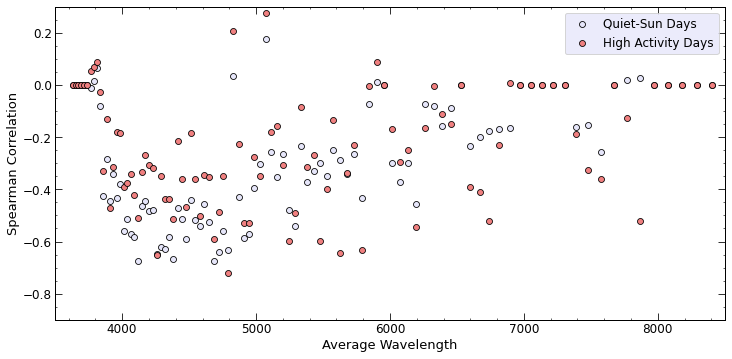

In [15]:
# plot style
plot_style = os.path.join(PlotDir.MPL, 'correlation.mplstyle')
plt.style.use(plot_style)

# calculate correlation coefficient
fig = plt.figure()
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.facecolor'] = 'white'
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

xlabel = 'Average Wavelength'
ylabel = 'Spearman Correlation'
x = waves
y = Bobs_corr
y_spot = Bobs_corr_spot
use = np.logical_and(x >= 2000, x <= 8500)
x = x[use]
y = y[use]
y_spot = y_spot[use]
# ax.scatter(x[~spot_days], y[~spot_days], color='plum', edgecolor='k', linewidth=0.8)
ax.scatter(x, y, color='lavender', edgecolor='k', linewidth=0.8, label='Quiet-Sun Days')
ax.scatter(x, y_spot, color='lightcoral', edgecolor='k', linewidth=0.8, label='High Activity Days')
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set(xlim = (3500, 8500), yticks = np.arange(3000, 8000, step=1000))
ax.set(ylim = (-0.9, 0.3), yticks = np.arange(-0.8, 0.23, step=.2))
ax.legend()

# Periodogram of integrated area

In [129]:
csv_file = os.path.join(CsvDir.CCFS, 'ccfs.csv')
dates, jd_dates, ccf_list, rv_sun, rv_model, rv_error, gaussian, rv_gauss, skew, int_area, Bobs, v_conv = utils.read_ccf_csv(csv_file)
# get other gaussian parameters
FWHM = [g.fwhm for g in gaussian]
amplitude = [g.amplitude.value for g in gaussian]
sigma = [g.stddev.value for g in gaussian]

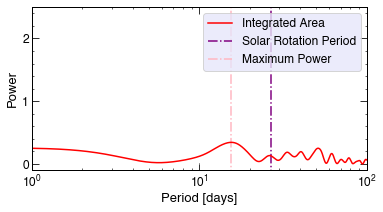

In [127]:
# periodogram of convective velocity components
jd = jd_dates - jd_dates[0]

# conv
drv_area = (int_area - np.mean(int_area)) * 1e2
ls_area = lombscargle(jd, drv_area, freqs)

# plot
plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
days = np.linspace(jd[0], jd[-1], 2500)
fig = plt.figure(figsize=[6, 3])

mx = np.argmax(ls_area[:2000])
plt.plot(days, ls_area, 'red', label='Integrated Area')
# plt.plot(days, ls_large, 'lightblue', label=r'$\rm v_{\rm conv, \, large}$')
plt.vlines([days[353]], -1, 5, colors='purple', linestyles='dashdot', label='Solar Rotation Period')
plt.vlines([days[mx]], -1, 5, colors='lightpink', linestyles='dashdot', label='Maximum Power')
plt.xlim(10e-1, 10e1)
plt.ylim(-0.1,2.5)
plt.yticks([0, 1, 2])
plt.xscale('log')
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.xlim(10e-1, 10e1)


plt.legend()

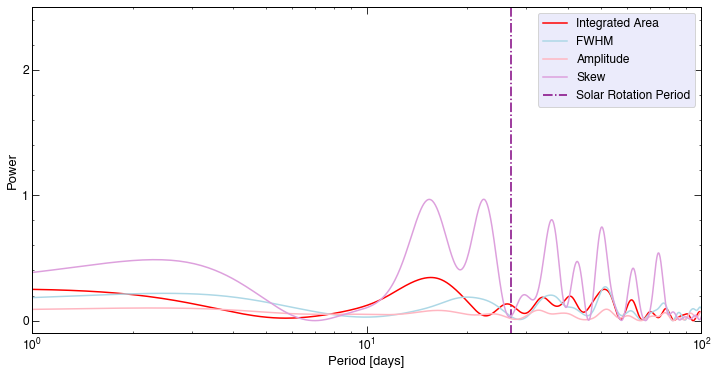

In [147]:
# periodogram of convective velocity components
jd = jd_dates - jd_dates[0]

# area
drv_area = (int_area - np.mean(int_area)) * 1e2
ls_area = lombscargle(jd, drv_area, freqs)

# fwhm
drv_fwhm = (FWHM - np.mean(FWHM)) * 1e2
ls_fwhm = lombscargle(jd, drv_fwhm, freqs) 

# amplitude
drv_amp = (amplitude - np.mean(amplitude)) * 1e3
ls_amp = lombscargle(jd, drv_amp, freqs)

# skew
drv_skew = (skew - np.mean(skew)) 
ls_skew = lombscargle(jd, drv_skew, freqs) 

# plot
plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
days = np.linspace(jd[0], jd[-1], 2500)
fig = plt.figure(figsize=[12, 6])

mx = np.argmax(ls_area[:2000])
plt.plot(days, ls_area, 'red', label='Integrated Area')
plt.plot(days, ls_fwhm, 'lightblue', label='FWHM')
plt.plot(days, ls_amp, 'lightpink', label='Amplitude')
plt.plot(days, ls_skew, 'plum', label='Skew')

plt.vlines([days[353]], -1, 5, colors='purple', linestyles='dashdot', label='Solar Rotation Period')
# plt.vlines([days[mx]], -1, 5, colors='lightpink', linestyles='dashdot', label='Maximum Power')
plt.xlim(10e-1, 10e1)
plt.ylim(-0.1, 2.5)
plt.yticks([0, 1, 2])
plt.xscale('log')
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.xlim(10e-1, 10e1)


plt.legend()

In [124]:
print(len(drv_area))
print(mx)

113
203


In [107]:
int_area - np.mean(int_area)

array([-5.61518556e-04,  4.55977517e-04, -2.93852945e-03, -4.00785312e-03,
       -3.78636557e-03, -3.86284028e-03, -7.13877136e-03, -1.54418380e-03,
        3.29970860e-03, -3.58299018e-03, -2.81864711e-03, -1.72329471e-03,
        7.05910520e-04, -1.39797658e-03,  3.96139804e-04, -1.41155192e-03,
        4.43137567e-03, -3.03682268e-03, -1.62447212e-03, -3.00469041e-03,
       -3.19026445e-03,  3.03152256e-04,  1.90154025e-03,  1.52517746e-03,
        3.18063865e-03, -3.07699951e-04, -2.76008390e-04,  1.38184877e-03,
        8.28936909e-03,  2.42708113e-03, -6.99207896e-04,  2.88362418e-03,
       -1.68902101e-04,  3.45389518e-04,  4.02151293e-04,  1.80877980e-03,
        3.01920050e-03,  4.35776468e-03,  1.96369895e-03,  3.96507663e-03,
        2.48566813e-03,  2.24744981e-03,  6.82603640e-03,  8.18890353e-03,
        3.62586905e-03,  5.58904625e-03,  9.93447258e-03,  2.24253081e-03,
        1.13399719e-02,  2.00789168e-03, -1.01740431e-03,  9.64947512e-03,
        2.34911724e-03,  